In [1]:
import warnings
warnings.filterwarnings("ignore")

# FEMA Exploratory Analysis

In [2]:
### Insert Packages

In [51]:
import time
import geopandas
import shapely
import glob
import kaleido
import datetime
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import seaborn as sns
import matplotlib as mpt
from matplotlib import cm
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from scipy.stats import zscore
from sklearn import tree, metrics
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge, ElasticNet, BayesianRidge, LinearRegression, LogisticRegression, RidgeClassifier, LogisticRegressionCV, SGDClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.svm import SVR, LinearSVC, NuSVC, SVC
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, ClassPredictionError, ClassificationReport, PrecisionRecallCurve
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.features import Rank2D, PCA, FeatureImportances
from yellowbrick.model_selection import CVScores, ValidationCurve
from yellowbrick.regressor import ResidualsPlot, PredictionError
from yellowbrick.target import ClassBalance

In [4]:
### Exploratory Data Analysis

In [5]:
# Read in the fema data
fema_vr = pd.read_csv(r"/Users/victoriawarner/Desktop/FEMA.csv")

In [6]:
# Eliminate the disasters that are not weather/precipitation-related.
fema_vr = fema_vr[fema_vr['incidentType']!="Biological"]
fema_vr = fema_vr[fema_vr['incidentType']!="Fire"]
fema_vr.head(5)

,Unnamed: 0,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,...,totalObligatedAmountPa,totalObligatedAmountCatAb,totalObligatedAmountCatC2g,paLoadDate,iaLoadDate,totalObligatedAmountHmgp,DecDatekey,IncidentEndDateKey,IncidentBeginDatekey,CloseOutDatekey
0,0,1306,FL,DR,10884,2000,Hurricane,0,0,1,...,1.062616e+08,32644798.12,72246572.61,2020-08-11T00:00:00.000Z,NaN,21423043.0,35-10884,35-10888,35-10878,35--106751
1,1,1306,FL,DR,10884,2000,Hurricane,0,1,1,...,1.062616e+08,32644798.12,72246572.61,2020-08-11T00:00:00.000Z,NaN,21423043.0,86-10884,86-10888,86-10878,86--106751
2,2,1306,FL,DR,10884,2000,Hurricane,0,1,0,...,1.062616e+08,32644798.12,72246572.61,2020-08-11T00:00:00.000Z,NaN,21423043.0,97-10884,97-10888,97-10878,97--106751
3,3,1306,FL,DR,10884,2000,Hurricane,0,1,1,...,1.062616e+08,32644798.12,72246572.61,2020-08-11T00:00:00.000Z,NaN,21423043.0,11-10884,11-10888,11-10878,11--106751
4,4,1306,FL,DR,10884,2000,Hurricane,0,1,1,...,1.062616e+08,32644798.12,72246572.61,2020-08-11T00:00:00.000Z,NaN,21423043.0,93-10884,93-10888,93-10878,93--106751


In [7]:
# Create a variable that describes the number of days of the disaster (i.e. the length).
fema_vr['disasterlength']=fema_vr.incidentEndDate-fema_vr.incidentBeginDate

In [8]:
# Create a varriable that describes the number of days after the begin of the disaster that the declaration was declared.
fema_vr['declarationtime']=fema_vr.declarationDate-fema_vr.incidentBeginDate

In [9]:
# Create a new dataframe that includes only the columns needed for analysis.
femalength = pd.DataFrame(fema_vr, columns = ['disasterNumber', 'incidentType', 
                                              'fyDeclared',
                                              'disasterlength', 'declarationtime'])
# Determine the shape of the dataframe.
femalength.shape

(1045, 5)

In [10]:
# Create a new dataframe that shows information per disaster number. 
femalength2 = femalength.groupby('disasterNumber', as_index = False).first()
femalength2.head(5)

,disasterNumber,incidentType,fyDeclared,disasterlength,declarationtime
0,1306,Hurricane,2000,10,6
1,1344,Severe Storm(s),2001,13,12
2,1345,Severe Storm(s),2001,7,0
3,1359,Freezing,2001,55,66
4,1381,Severe Storm(s),2001,4,6


In [11]:
# Eliminate values that do not make sense, rename columns appropriately, and describe the dataframe mathematically.
femalength2 = femalength2[femalength2.disasterlength >= 0]
femalength2 = femalength2.rename(columns={'incidentType':'Disaster', 
                                         'fyDeclared':'Year'})
femalength2.describe()

,disasterNumber,Year,disasterlength,declarationtime
count,42.000000,42.000000,42.000000,42.000000
mean,2663.357143,2009.119048,20.833333,14.119048
std,1176.886878,6.511537,18.144295,18.378410
min,1306.000000,2000.000000,0.000000,0.000000
25%,1553.500000,2004.000000,7.000000,2.000000
50%,2495.000000,2008.000000,13.000000,6.000000
75%,3419.750000,2016.750000,31.750000,21.000000
max,4468.000000,2020.000000,70.000000,66.000000


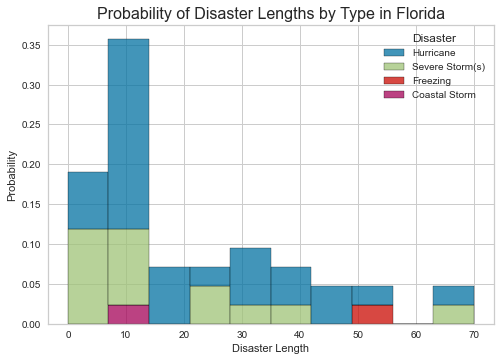

In [12]:
# Create a plot that shows the probability of the lengths of the disasters by disaster type.
# Use probability as a means to normalize the histogram.
fig, ax = plt.subplots()
sns.histplot(femalength2, x="disasterlength", bins=10, hue = 'Disaster', multiple="stack", stat="probability", ax=ax)
ax.set(xlabel="Disaster Length",
      ylabel="Probability");
ax.set_title("Probability of Disaster Lengths by Type in Florida", fontsize = 16)
plt.savefig("probability.png")

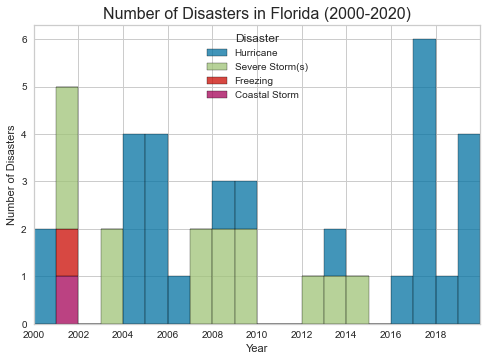

In [13]:
# Create a stacked plot that shows the number of disasters in Florida for the past 20 years. 
fig, ax = plt.subplots()
sns.histplot(femalength2, x="Year", binwidth=1, hue = 'Disaster', multiple="stack", ax=ax)
ax.set(xlabel="Year",
      ylabel="Number of Disasters");
ax.set_title("Number of Disasters in Florida (2000-2020)", fontsize = 16);
ax.set(xticks=np.arange(2000,2020, step=2), xlim=(2000,2020));
plt.savefig("year.png")

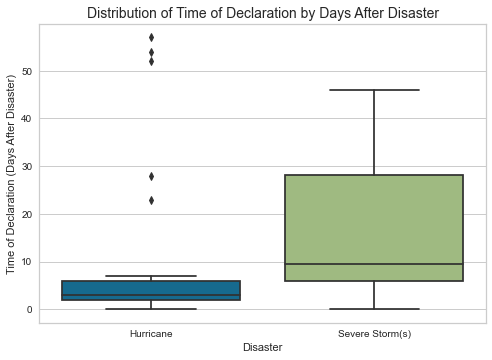

In [14]:
# Create a boxplot that shows the distribution of the times of declaration in days after the disaster to better
# understand the timeframe for declaration and how to incorporate this into the model.
fema4 = femalength2[femalength2.Disaster.isin(["Hurricane", "Severe Storm(s)"])]
fig, ax = plt.subplots()
sns.boxplot(data=fema4, x="Disaster", y="declarationtime")
ax.set(
      ylabel="Time of Declaration (Days After Disaster)");
ax.set_title("Distribution of Time of Declaration by Days After Disaster", fontsize = 14);
plt.savefig("declarationtime.png")

In [15]:
# Determine the median by disaster type of the variables by grouping.
fema4.groupby('Disaster', as_index=False).median()

,Disaster,disasterNumber,Year,disasterlength,declarationtime
0,Hurricane,3335.0,2011.0,15.0,3.0
1,Severe Storm(s),1732.5,2007.5,9.5,9.5


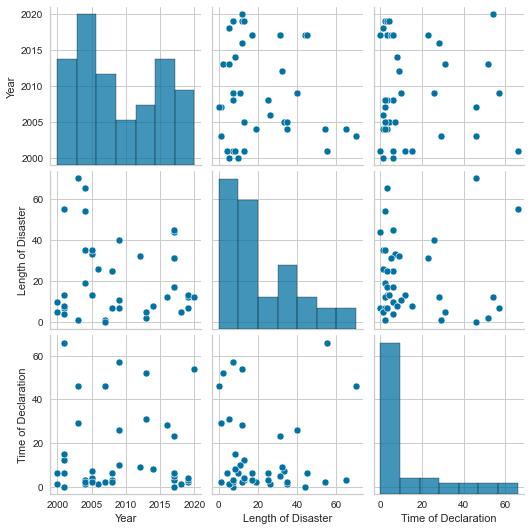

In [16]:
# Create a pairplot to compare the three variables visually: year, time of declaration (in days after incident),
# and the length (in days) of the disaster.
femalength3 = femalength2.drop(columns = ['disasterNumber'])
femalength3 = femalength3.rename(columns={'declarationtime':'Time of Declaration', 
                                         'disasterlength':'Length of Disaster'})
sns.pairplot(femalength3)
plt.savefig("pairplot.png")